In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Some helper

In [4]:
class PeriodicBasis(torch.nn.Module):
    
    def forward(self, x):
        return torch.cat([
            (2 * np.pi * x).cos(),
            (2 * np.pi * x).sin()
        ], dim=-1)

In [97]:
from bgflow import (
    DenseNet,
    
    WrapCDFTransformerWithInverse,
    GridInversion,
    AffineSigmoidComponentInitGrid,
    
    MixtureCDFTransformer,
    AffineSigmoidComponents,   
    MoebiusComponents,
    
    SmoothRamp,
    SmoothRampWithTrainableExponent,
    BisectionRootFinder,
    
    ConstrainedBoundaryCDFTransformer,
    
    SequentialFlow,
    CouplingFlow,
    SplitFlow,
    InverseFlow,
    SwapFlow,
    
)
    
from toy_data.toy_data import dataset_names, inf_train_gen

from matplotlib.colors import LogNorm


def plot_transformer_density(transformer, label, grid_size=100):
    with torch.enable_grad():
        ys = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
        xs = torch.zeros_like(ys)
        ys_, dlogp_ = transformer(xs, ys)
        computed_density = dlogp_.exp()
        ad_density = torch.autograd.grad(ys_.sum(), ys, create_graph=True)[0]
        
        plt.figure(figsize=(10, 3))
        plt.title(label)
        plt.plot(ys.detach(), ys_.detach(), label="cdf")
        plt.plot(ys.detach(), computed_density.detach(), alpha=0.5, label="computed pdf")
        plt.plot(ys.detach(), ad_density.detach(), linestyle="--", label="AD pdf")
        plt.legend()
        
def make_net(d_in, d_hidden, d_out, activation, periodic=False):
    return torch.nn.Sequential(
        PeriodicBasis() if periodic else torch.nn.Identity(),
        DenseNet([d_in * (2 if periodic else 1), d_hidden, d_hidden, d_out], activation)
    )

def make_transformer(
    d_in,
    d_out,
    d_hidden,
    n_components,
    periodic=False,
    zero_boundary_left=False,
    zero_boundary_right=False,
    activation=torch.nn.SiLU(),
    smoothness_type="type1",
    init_weight=1.,
    min_density=1e-6,
    verbose=False
):
    return WrapCDFTransformerWithInverse(
        transformer=(
            t:=MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                compute_components=MoebiusComponents(
                    compute_params=make_net(d_in, d_hidden, d_out * n_components * 3, activation, periodic=periodic)
                )
#                 compute_components=AffineSigmoidComponents(
# #                     conditional_ramp=SmoothRampWithTrainableExponent(
# #                         compute_params=make_net(d_in, d_hidden, d_out * n_components * 2, activation, periodic=periodic)
# #                     ),
#                     conditional_ramp=SmoothRamp(
#                         compute_alpha=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
#                         unimodal=False,
#                         ramp_type=smoothness_type
#                     ),
#                     log_sigma_bound=torch.tensor(10.),
#                     compute_params=make_net(d_in, d_hidden, d_out * (3 * n_components), activation, periodic=periodic),
#                     min_density=torch.tensor(min_density),
#                     periodic=periodic,
#                     zero_boundary_left=zero_boundary_left,
#                     zero_boundary_right=zero_boundary_right

#                 ),
            )
        ),
        oracle=GridInversion(
            transformer=t,
            compute_init_grid=lambda x,y: torch.linspace(0, 1, 100).view(-1, 1, 1).repeat(1, *y.shape).to(y),
#             compute_init_grid=AffineSigmoidComponentInitGrid(
#                 t._compute_components
#             ),
            verbose=verbose
        )
    )


def make_constrained_transformer(transformer, left_bound=None, right_bound=None,  smoothness_type="type1"):
    def compute_constraints(x):
        bounds = []
        if left_bound is not None:
            bounds.append(torch.tensor([left_bound]).log().expand_as(x))
        if right_bound is not None:
            bounds.append(torch.tensor([right_bound]).log().expand_as(x))
        return torch.stack(bounds, dim=-1)
    
    return ConstrainedBoundaryCDFTransformer(
        transformer=transformer,
        compute_constraints=compute_constraints,
        left_constraint=left_bound is not None,
        right_constraint=right_bound is not None,
        smoothness_type=smoothness_type
    )


def make_coupling_flow(transformer_factory):    
    return SequentialFlow([
        SplitFlow(1),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        InverseFlow(SplitFlow(1))
    ])

def train(flow, dataset="pinwheel", train_with_inverse=False, batch_size=1_000, learning_rate=1e-3, n_iters=1_000, print_interval=100, cuda=False):
    optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)
    for it in range(n_iters):
        x = (inf_train_gen(dataset, batch_size=batch_size) + 4) / 8
        x = torch.FloatTensor(x) % 1    
        if cuda:
            x = x.cuda()
        y, dlogp = flow(x, inverse=train_with_inverse)    
        nll = -dlogp.mean()    
        optim.zero_grad()
        nll.backward()
        optim.step()
        if not it % print_interval:            
            print(f"it: {it}/{n_iters}, nll: {nll.item():.4}", end="\r")
            

            
def plot_evaluation(flow, dataset="pinwheel", train_with_inverse=False, n_samples=100_000, use_log_norm=True, cuda=False, eps=0.):
    
    print("Computing energy plot...")
    with torch.no_grad():
        xs = torch.meshgrid(
            torch.linspace(0 - eps, 1 + eps, 100),
            torch.linspace(0 - eps, 1 + eps, 100)
        )
        xs = torch.stack(xs, dim=-1).view(-1, 2) % 1
        if cuda:
            xs = xs.cuda()
        ys, dlogp = flow(xs, inverse=train_with_inverse)
        u = -dlogp
        u = u.view(100, 100)
        if cuda:
            u_ = u.cpu().detach()
            del u
            del xs
            u = u_
        
        
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    plt.figure(figsize=(8, 8))
    plt.title("Energy")
    plt.imshow((-u).exp().detach(), norm=norm)
    
    print("Sampling ground truth...")
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    x = (inf_train_gen(dataset, batch_size=n_samples) + 4) / 8
    x = torch.FloatTensor(x) % 1
    plt.figure(figsize=(8, 8))
    plt.title("Ground truth samples")
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));
    
    print("Sampling model...")
    
    with torch.no_grad():
        z = torch.rand(n_samples, 2)
        if cuda:
            z = z.cuda()
        x, _ = flow(z, inverse=not train_with_inverse)
        if cuda:
            x_ = x.cpu().detach()
            del x
            del z
            x = x_
    plt.figure(figsize=(8, 8))
    plt.title("Flow samples")
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));

## How to create compact transformers

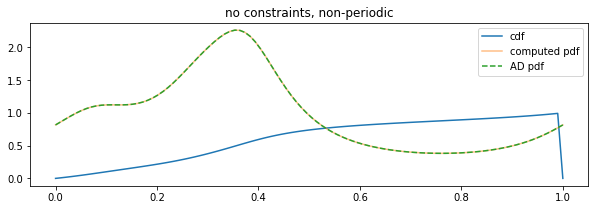

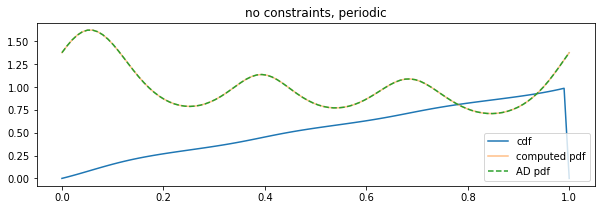

In [48]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, non-periodic"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=True, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, periodic"
)

## Zero density constraint at boundary

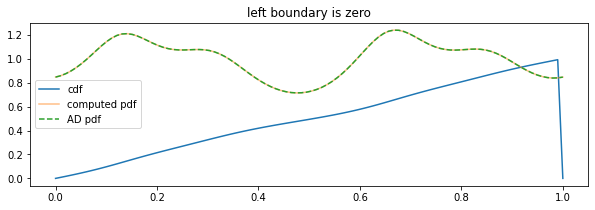

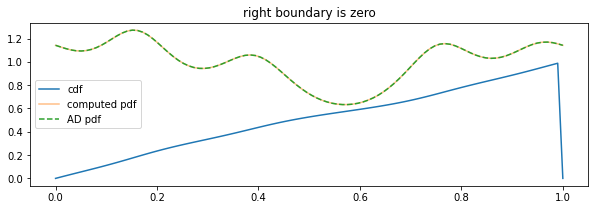

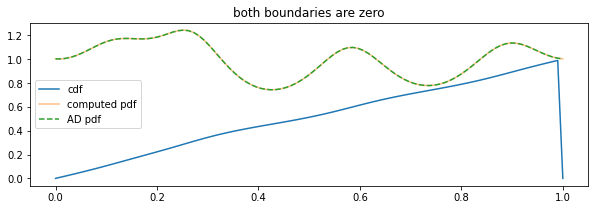

In [49]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
    label="left boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
    label="right boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True),
    label="both boundaries are zero"
)

## Value constraint at boundary

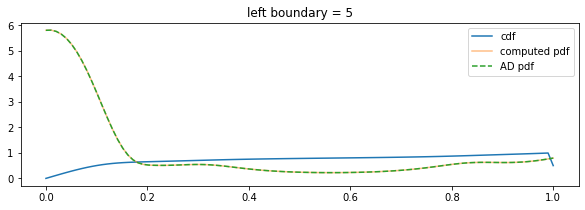

In [50]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
        left_bound=5.
    ),
    label="left boundary = 5"
)

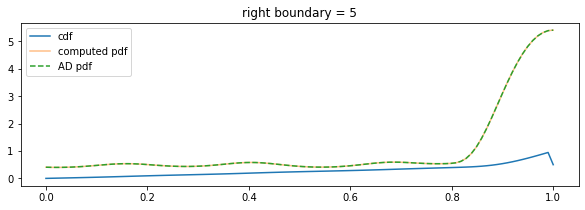

In [51]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
        right_bound=5.
    ),
    label="right boundary = 5"
)

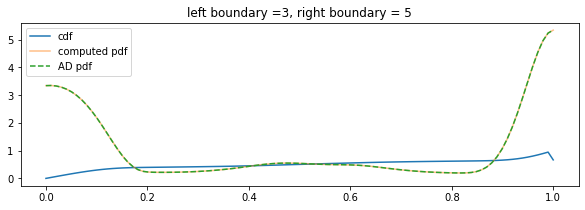

In [52]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True, smoothness_type="type1"),
        left_bound=3.,
        right_bound=5.,
        smoothness_type="type1"
    ),
    label="left boundary =3, right boundary = 5"
)

## Density Estimation Example

In [102]:
from functools import partial

flow = make_coupling_flow(partial(make_transformer, d_in=1, d_out=1, d_hidden=100, n_components=20, periodic=True, verbose=False)).cuda()

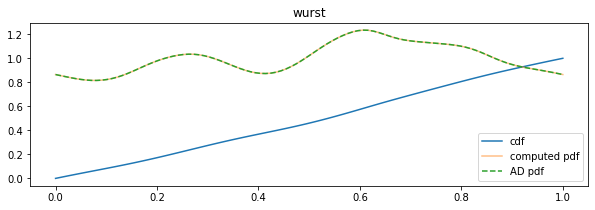

In [103]:
plot_transformer_density(
    partial(flow._blocks[3].transformer.cpu(), inverse=True),
    label="wurst"
)

In [104]:
flow = flow.cuda()

In [106]:
train(flow, cuda=True, train_with_inverse=False)

In [109]:
flow = flow.cuda()

Computing energy plot...
Sampling ground truth...
Sampling model...


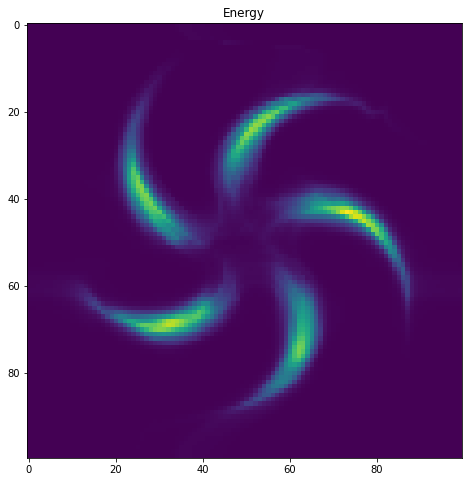

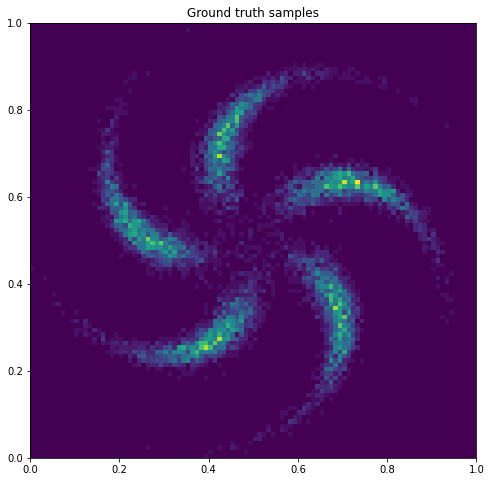

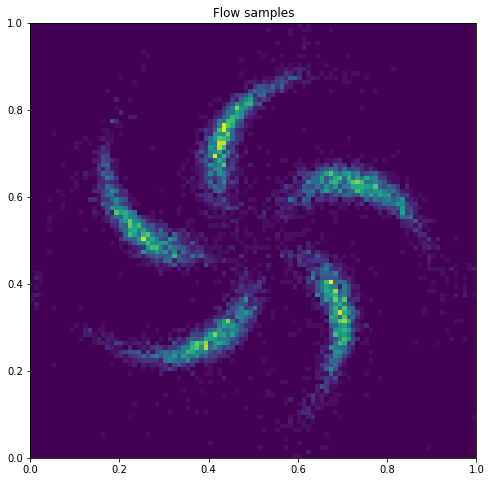

In [110]:
plot_evaluation(flow, cuda=True, n_samples=10_000, use_log_norm=False, train_with_inverse=False, eps=0.0)